# Stochastic Simulation Assignment 1

## Computing the Area of the Mandelbrot Set
_Authors: Sai Vinay Vardhan Daliparthi (15073815), Boyan Mihaylov (15067602), Nitai Nijholt (12709018)_

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random


## Mandelbrot Simulation

The following functions compute the Mandelbrot set by iterating a regular rectangular grid of complex numbers through a recursive function.

In [5]:
# creating the coordinate plane
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
wsteps, hsteps = 1000, 1000
r1 = np.linspace(xmin, xmax, wsteps)
r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
real_array, complex_array = np.meshgrid(r1,r2_imaginary)
complex_coordinate_plane = real_array + complex_array


In [6]:
def vectorized_mandlebrot(complex_coordinate_plane, max_iter, threshold):
    z = complex_coordinate_plane.copy()
    diverged_at = np.full(z.shape, max_iter)

    for n in range(max_iter):
        diverged = abs(z) > threshold
        diverged_at[diverged & (diverged_at == max_iter)] = n
        z[~diverged] = z[~diverged]**2 + complex_coordinate_plane[~diverged]

    return diverged_at

    

In [7]:
def calculate_mandelbrot_vectorized(xmin,xmax,ymin,ymax,wsteps,hsteps,max_iter, threshold):
    r1 = np.linspace(xmin, xmax, wsteps)
    r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
    real_array, complex_array = np.meshgrid(r1,r2_imaginary)
    complex_coordinate_plane = real_array + complex_array
    output = vectorized_mandlebrot(complex_coordinate_plane, max_iter, threshold)
    return output

        


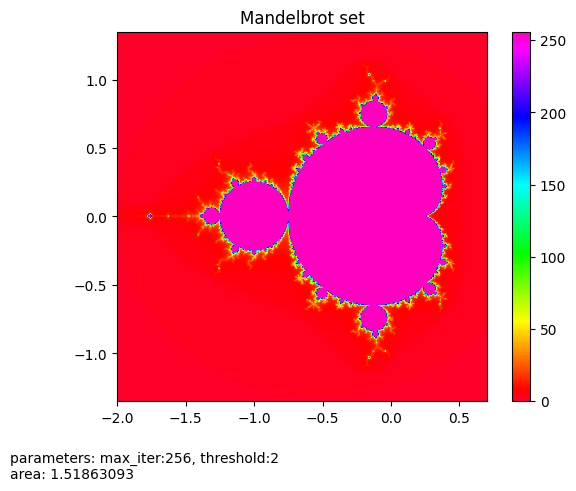

In [8]:
# xmin, xmax, ymin, ymax = -1.3, -1.05, -0.45, -0.2
# wsteps, hsteps = 1000, 1000


xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
wsteps, hsteps = 1000, 1000
max_iter = 256
threshold = 2


test_vectorized_mandelbrot = calculate_mandelbrot_vectorized(xmin,xmax,ymin,ymax,wsteps,hsteps,256, 2)
pt_area = (xmax - xmin) * (ymax - ymin) / (wsteps * hsteps)
area = np.sum(np.where(test_vectorized_mandelbrot == np.max(test_vectorized_mandelbrot), 1, 0)) * pt_area
plt.imshow(test_vectorized_mandelbrot, extent=(xmin, xmax, ymin, ymax), cmap='gist_rainbow')
plt.title("Mandelbrot set")
plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}\narea: {area}', horizontalalignment='left')
plt.colorbar()
plt.show()

## Approximating the Area

For a dense rectangular grid of points it is assumed that the area around the point can be calculated as:

$$
A_{pt}=\frac{1}{n_x n_y}A_R
$$

where $A_R$ is the area of the bounding region ($A_R=w\times h$) and $n_x$ and $n_y$ are the number of grid cells in $x$ and $y$ direction, respectively.

Then, to calculate the area $A_M$ of the Mandelbrot set we count the points which do not escape under the iteration function ($N_M$) and approximate the area as:

$$
A_M = N_M A_{pt}
$$

## Stochastic Sampling of the Mandelbrot set

The following function is a variation of the Mandelbrot iterator, this time iterating randomly sampled points instead of a regular grid.

In [11]:
def calculate_mandelbrot_stochastic(xmin,xmax,ymin,ymax,n_samples,max_iter, threshold):
    '''Generates random point samples for the iteration function and passes it to the Mandelbrot function.
    Returns the initial point positions and the iterations until divergence above the threshold.'''
    c_samples = np.random.uniform((xmin, ymin), (xmax, ymax), (n_samples, 2))
    n3 = np.empty(n_samples)
    z_last = np.empty(n_samples, dtype=np.csingle)
    for i in range(n_samples):
        imaginary_component = 1j
        c = c_samples[i]
        n3[i], z_last[i] = Mandelbrot(c[0] + imaginary_component*c[1], max_iter, threshold)
    return (c_samples, n3, z_last)

The procedure below executes the stochastic Mandelbrot iteration and plots the following results:
- a scatterplot of the initial sampling of the space with a colour assigned to each sample depending on the number of iterations before their divergence;
- a scatterplot of the iterated positions of the samples, colours analogous to the above.

The purpose of the second plot is to observe the change in distribution of the samples after iteration, exploring the possibilities for resampling specific regions during the iteration process.

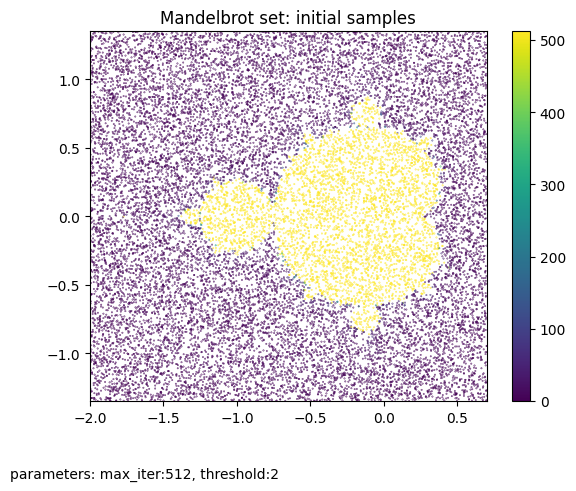

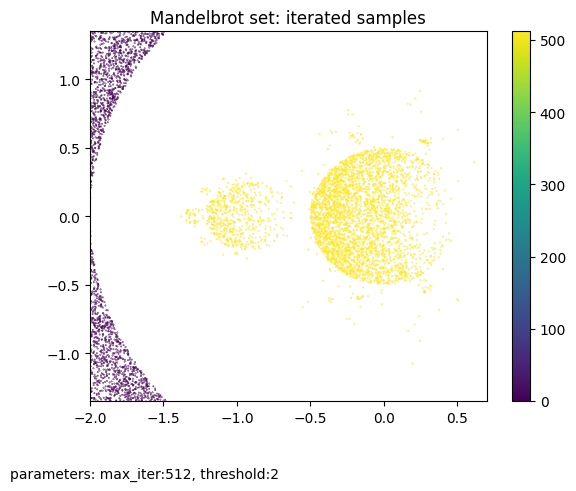

In [12]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
n_samples = 20000

# parameters
max_iter = 512
threshold = 2

pts, iter, z_last = calculate_mandelbrot_stochastic(xmin,xmax,ymin,ymax,n_samples,max_iter,threshold=2)

plt.scatter(pts.T[0], pts.T[1], c=iter, s=0.1)
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))
plt.title("Mandelbrot set: initial samples")
plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}', horizontalalignment='left')
plt.colorbar()
plt.show()

plt.scatter(z_last.real, z_last.imag, c=iter, s=0.1)
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))
plt.title("Mandelbrot set: iterated samples")
plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}', horizontalalignment='left')
plt.colorbar()
plt.show()

In [13]:
def calculate_area_random_sampling(xmin,xmax,ymin,ymax,wsteps,hsteps,threshold,iterations,sample_size,seed=None):
    
    r1 = np.linspace(xmin, xmax, wsteps)
    r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
    real_array, complex_array = np.meshgrid(r1,r2_imaginary)
    complex_coordinate_plane = real_array + complex_array
    # Implement random Sampling from the complex coordinate plane
    sampled_complex_coordinate_plane = np.array(random.sample(list(complex_coordinate_plane.flatten()),sample_size))
    output = vectorized_mandlebrot(sampled_complex_coordinate_plane, iterations, threshold)
    area = (np.sum(np.where(output == np.max(output), 1, 0)) / output.size ) * ((xmax - xmin) * (ymax - ymin))
    return area, output.shape

In [14]:
def calculate_area_random_sampling_new(xmin,xmax,ymin,ymax,wsteps,hsteps,threshold,iterations,sample_size,seed=None):
    
    r1 = np.linspace(xmin, xmax, wsteps)
    r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
    real_array, complex_array = np.meshgrid(r1,r2_imaginary)
    complex_coordinate_plane = real_array + complex_array
    indices = np.random.randint((0 , 0), (wsteps , hsteps), (sample_size, 2))
    print(indices)
    print(type(indices))
    # return indices
    sampled_complex_coordinate_plane = complex_coordinate_plane[indices]
    output = vectorized_mandlebrot(sampled_complex_coordinate_plane, iterations, threshold)
    area = (np.sum(np.where(output == np.max(output), 1, 0)) / output.size ) * ((xmax - xmin) * (ymax - ymin))
    return area, output.shape

In [15]:
def calculate_area_random_sampling(xmin, xmax, ymin, ymax, wsteps, hsteps, threshold, iterations, sample_size, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    # Sample directly without creating the meshgrid
    real_samples = np.random.uniform(xmin, xmax, sample_size)
    imag_samples = np.random.uniform(ymin, ymax, sample_size)
    sampled_complex_coordinates = real_samples + 1j * imag_samples

    output = vectorized_mandlebrot(sampled_complex_coordinates, iterations, threshold)
    
    max_val = np.max(output)
    area_ratio = np.sum(output == max_val) / sample_size
    total_area = (xmax - xmin) * (ymax - ymin)
    
    return area_ratio * total_area, output.shape

In [18]:
print(calculate_area_random_sampling(-2.0, 0.7, -1.35, 1.35, 10000, 10000, 2, 256, 1000))

(1.5819300000000003, (1000,))


In [ ]:
print(calculate_area_random_sampling(-2.0, 0.7, -1.35, 1.35, 10000, 10000, 2, 256, 10000))

(1.5338160000000003, (10000,))
